In [1]:
import numpy as np
import pandas as pd 
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

In [2]:
# Load the training data 
training_data = bz2.BZ2File("C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\train.ft.txt.bz2")
training_data = training_data.readlines()
training_data = [x.decode('utf-8') for x in training_data]
print(len(training_data))

# Load the test data 
test_data = bz2.BZ2File("C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\test.ft.txt.bz2")
test_data = test_data.readlines()
test_data = [x.decode('utf-8') for x in test_data]
print(len(test_data))

3600000
400000


In [3]:
# Split the data into labels and texts
traing_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
trainig_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# Convert labels to binary (0 and 1)
traing_labels = [0 if label == 1 else 1 for label in traing_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]


def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text


trainig_texts=pd.DataFrame(trainig_texts)[0].apply(clean_text)
test_texts=pd.DataFrame(test_texts)[0].apply(clean_text)

In [4]:
pd.DataFrame(test_labels).value_counts()

0
0    200000
1    200000
Name: count, dtype: int64

In [15]:
max_words = 1000
max_sequence_length = 100

In [14]:
# # Tokenization and padding


# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(trainig_texts)

# X_train = tokenizer.texts_to_sequences(trainig_texts)
# X_test = tokenizer.texts_to_sequences(test_texts)

# X_train = pad_sequences(X_train, maxlen=max_sequence_length)
# X_test = pad_sequences(X_test, maxlen=max_sequence_length)
# import json
# # Save tokenized data
# with open('X_train.json', 'w') as f:
#     json.dump(X_train.tolist(), f)  # Convert numpy arrays to list for JSON serialization

# with open('X_test.json', 'w') as f:
#     json.dump(X_test.tolist(), f)

# tokenizer_json = tokenizer.to_json()
# with open('tokenizer.json', 'w') as f:
#     f.write(tokenizer_json)

In [11]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json
# Load tokenized data
with open('X_train.json', 'r') as f:
    X_train = json.load(f)
    X_train = np.array(X_train)  # Convert list back to numpy array

with open('X_test.json', 'r') as f:
    X_test = json.load(f)
    X_test = np.array(X_test)

# Load tokenizer
with open('tokenizer.json', 'r') as f:
    tokenizer_data = f.read()
    tokenizer = tokenizer_from_json(tokenizer_data)


In [12]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(traing_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(3600000, 100)
(400000, 100)
(3600000,)
(400000,)


In [13]:
# Assuming X_train and y_train have been converted to NumPy arrays as shown
X_train = X_train[:len(X_train)//10]
X_test = X_test[:len(X_test)//10]
y_train = y_train[:len(y_train)//10]
y_test = y_test[:len(y_test)//10]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(360000, 100)
(40000, 100)
(360000,)
(40000,)


In [ ]:
## Create the model

# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(rate=0.2))  
# model.add(LSTM(units=128))
# model.add(Dense(1,activation='sigmoid'))
# model.summary()

# model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=2, batch_size=2048, verbose=1, validation_split=.1)

In [16]:
def create_model(optimizer, activation_function, lstm_layers):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
    for _ in range(lstm_layers):
        model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(1, activation=activation_function))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

configurations = [
    {"optimizer": SGD(learning_rate=0.001), "activation_function": 'sigmoid', "lstm_layers": 1},
    {"optimizer": SGD(learning_rate=0.001), "activation_function": 'relu', "lstm_layers": 1},
    {"optimizer": Adam(learning_rate=0.001), "activation_function": 'sigmoid', "lstm_layers": 2},
    {"optimizer": Adam(learning_rate=0.001), "activation_function": 'relu', "lstm_layers": 2},
    
]

models = []
results = []
# Train models and collect them
for config in configurations:
    model = create_model(config["optimizer"], config["activation_function"], config["lstm_layers"])
    model.fit(X_train, y_train, epochs=3, batch_size=128, verbose=1)
    loss, accuracy = model.evaluate(X_test, y_test)
    results.append({"config": config, "loss": loss, "accuracy": accuracy})
    models.append(model)

Epoch 1/3
2813/2813 [==============================] - 807s 286ms/step - loss: 0.6930 - accuracy: 0.5090
Epoch 2/3
2813/2813 [==============================] - 808s 287ms/step - loss: 0.6929 - accuracy: 0.5065
Epoch 3/3
1250/1250 [==============================] - 41s 33ms/step - loss: 0.6928 - accuracy: 0.5090
Epoch 1/3
2813/2813 [==============================] - 1319s 466ms/step - loss: 7.5242 - accuracy: 0.5066
Epoch 2/3
2813/2813 [==============================] - 1271s 452ms/step - loss: 7.5252 - accuracy: 0.5065
Epoch 3/3
1250/1250 [==============================] - 35s 27ms/step - loss: 7.4878 - accuracy: 0.5090
Epoch 1/3
2813/2813 [==============================] - 1972s 698ms/step - loss: 0.2943 - accuracy: 0.8749
Epoch 2/3
2813/2813 [==============================] - 2012s 715ms/step - loss: 0.2400 - accuracy: 0.9015
Epoch 3/3
1250/1250 [==============================] - 68s 54ms/step - loss: 0.2229 - accuracy: 0.9097
Epoch 1/3
2813/2813 [==============================] - 18

In [22]:
import os

model_save_path = "C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models2"  # Define path to save models

for idx, model in enumerate(models):
    model_directory = os.path.join(model_save_path, f'model_{idx + 1}')
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)
    model.save(os.path.join(model_directory, 'model.h5'))  # Save each model


c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
for result in results:
    config = result["config"]
    loss = result["loss"]
    accuracy = result["accuracy"]
    print(f"Configuration: Optimizer={config['optimizer']}, Activation={config['activation_function']}, LSTM Layers={config['lstm_layers']}")
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}\n")

Configuration: Optimizer=<keras.src.optimizers.sgd.SGD object at 0x0000024CBDAE54F0>, Activation=sigmoid, LSTM Layers=1
Test Loss: 0.692818820476532, Test Accuracy: 0.5089750289916992

Configuration: Optimizer=<keras.src.optimizers.sgd.SGD object at 0x0000024CBDAE5970>, Activation=relu, LSTM Layers=1
Test Loss: 7.487751483917236, Test Accuracy: 0.5089750289916992

Configuration: Optimizer=<keras.src.optimizers.adam.Adam object at 0x0000024C177E48E0>, Activation=sigmoid, LSTM Layers=2
Test Loss: 0.2229316383600235, Test Accuracy: 0.9096500277519226

Configuration: Optimizer=<keras.src.optimizers.adam.Adam object at 0x0000024C177E4C10>, Activation=relu, LSTM Layers=2
Test Loss: 0.2662352919578552, Test Accuracy: 0.8888750076293945



In [25]:
from tensorflow.keras.models import load_model

model_1 = load_model('C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models2\\model_1\\model.h5')
model_2 = load_model('C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models2\\model_2\\model.h5')
model_3 = load_model('C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models2\\model_3\\model.h5')
model_4 = load_model('C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models2\\model_4\\model.h5')

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_test is your test dataset
def cm_report(model, X_test, y_test, threshold=0.5 ):
    if model is None or X_test is None or y_test is None:
        raise ValueError("Model, X_test, and y_test must be provided")
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    return cm, report, y_pred



def cm_plot(cm):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Parameters:
    - cm: Confusion matrix array.
    
    Returns:
    - None: Displays the heatmap of the confusion matrix.
    """
    # Create a heatmap to visualize the confusion matrix.
    plt.figure(figsize=(8, 6))  # Set the figure size for better readability
    sns.heatmap(cm, annot=True, center=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    


In [27]:
cm_1, report_1, ypred_1 = cm_report(model_1, X_test, y_test)
cm_2, report_2, ypred_2 = cm_report(model_2, X_test, y_test)
cm_3, report_3, ypred_3 = cm_report(model_3, X_test, y_test)
cm_4, report_4, ypred_4 = cm_report(model_4, X_test, y_test)

1250/1250 [==============================] - 34s 27ms/step
Confusion Matrix:
[[    0 19641]
 [    0 20359]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19641
           1       0.51      1.00      0.67     20359

    accuracy                           0.51     40000
   macro avg       0.25      0.50      0.34     40000
weighted avg       0.26      0.51      0.34     40000



C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

1250/1250 [==============================] - 33s 26ms/step
Confusion Matrix:
[[    0 19641]
 [    0 20359]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     19641
           1       0.51      1.00      0.67     20359

    accuracy                           0.51     40000
   macro avg       0.25      0.50      0.34     40000
weighted avg       0.26      0.51      0.34     40000



C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\raghu\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

1250/1250 [==============================] - 53s 42ms/step
Confusion Matrix:
[[18002  1639]
 [ 1975 18384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     19641
           1       0.92      0.90      0.91     20359

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

1250/1250 [==============================] - 56s 44ms/step
Confusion Matrix:
[[17176  2465]
 [ 1980 18379]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     19641
           1       0.88      0.90      0.89     20359

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



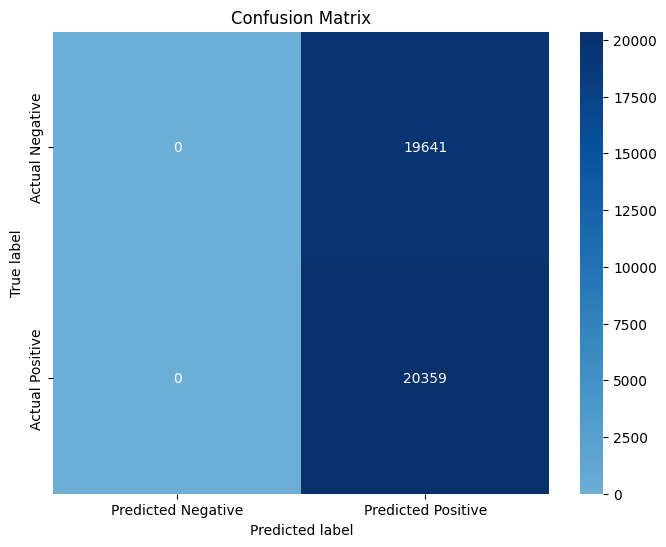

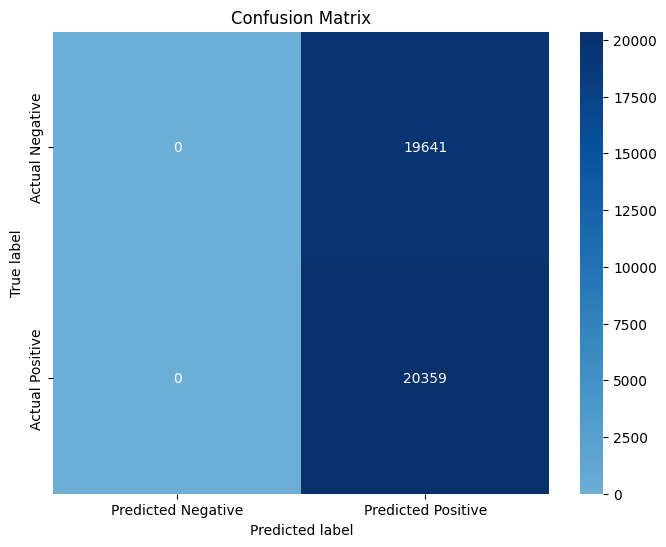

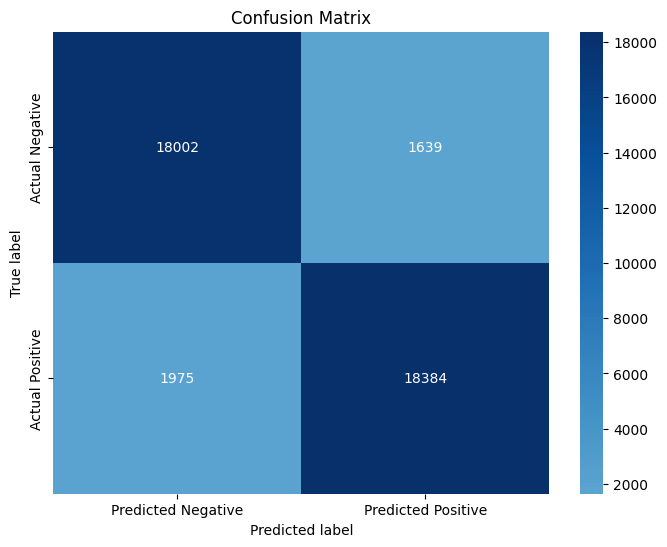

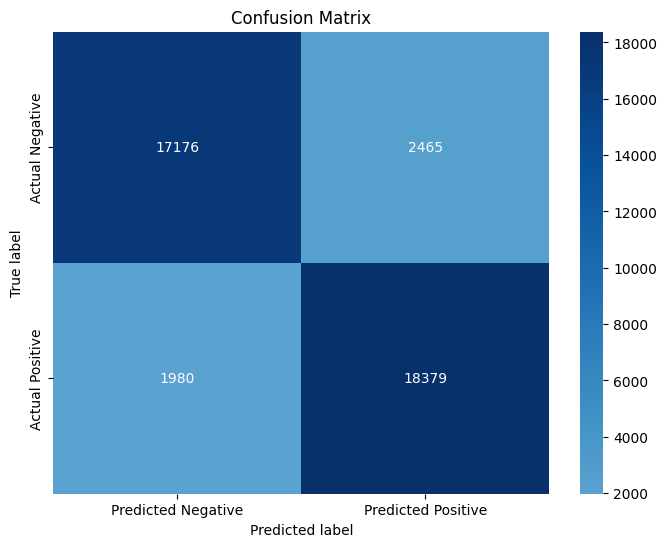

In [28]:
cm_plot(cm_1)
cm_plot(cm_2)
cm_plot(cm_3)
cm_plot(cm_4)

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_multiple_roc(scores_dict, y_test):
    """
    Plots ROC curves for multiple sets of predictions.
    
    Parameters:
    - scores_dict: Dictionary of prediction scores with names as keys and score arrays as values.
    - y_test: Actual labels of the test dataset.
    """
    plt.figure(figsize=(10, 8))
    
    for name, scores in scores_dict.items():
        # Compute ROC curve and ROC area for each set of scores
        fpr, tpr, _ = roc_curve(y_test, scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    
    # Plot baseline (random performance)
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (area = 0.50)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


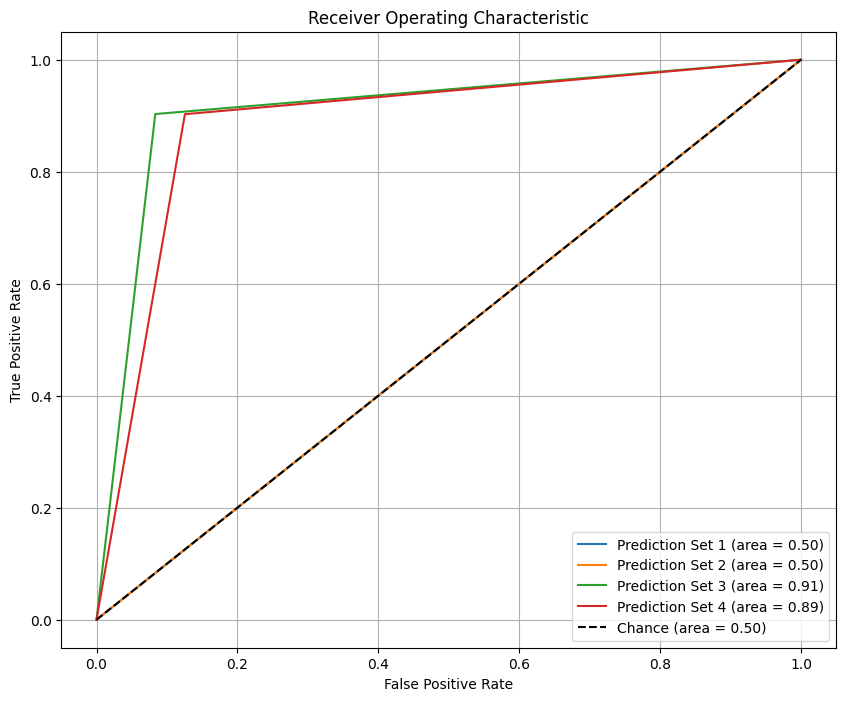

In [30]:
scores_dict = {
    'Prediction Set 1': ypred_1,
    'Prediction Set 2': ypred_2,
    'Prediction Set 3': ypred_3,
    'Prediction Set 4': ypred_4,
}

plot_multiple_roc(scores_dict, y_test)


In [53]:
def build_model():
    # Load and optionally recompile the model here
    model = load_model('C:\\Users\\raghu\\CS6120_mywork_NLP\\Fianl_project\\models\\model_2\\model.h5')
    # Ensure the model is compiled correctly, you might need to recompile if changing any training parameters
    return model
